In [174]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from six import StringIO 
from IPython.display import Image as Img  
import pydotplus
import graphviz
from pydot import graph_from_dot_data
import pydot

In [175]:
from fastseg import MobileV3Large

In [176]:
model = MobileV3Large(num_classes=19, use_aspp=True, num_filters=256)
model = model.from_pretrained(num_filters=256)

Loading pretrained model mobilev3large-lraspp with F=256...


In [177]:
img = Image.open("../data/utube/Kochi 4K _ Driving from Kakkanad to Kaloor by sunset 24-41 screenshot.png")
labels = model.predict_one(img)

In [178]:
labels.shape

(1080, 1920)

In [179]:
labels

array([[10, 10, 10, ...,  5,  5,  5],
       [10, 10, 10, ...,  5,  5,  5],
       [10, 10, 10, ...,  5,  5,  5],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [180]:
classes, counts = np.unique(labels, return_counts=True)
classes, counts, counts.sum()

(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]),
 array([571909,  19333, 567996,  15262,  32790,  18517,   1460, 339605,
         42222, 307525,  13580,  10107,  76213,  16147,  19551,     13,
         20035,   1335]),
 2073600)

In [181]:
class_names = ["road", "sidewalk", "building", "wall", "fence", "pole", "traffic_light", "traffic_sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"]
len(class_names)

19

In [182]:
img_class_counts = {}

In [183]:
img_dir = "../data/utube"

In [184]:
# for img_path in os.listdir(img_dir):
#     print(f"Processing image {img_path}")
#     img = Image.open(os.path.join(img_dir, img_path))
#     labels = model.predict_one(img)
#     _, counts = np.unique(labels, return_counts=True)
#     n_pixels = labels.size
#     counts = counts/ n_pixels
#     img_class_counts[img_path] = counts

In [185]:
with open("img_class_counts.pkl", 'rb') as f:
    img_class_counts = pickle.load(f)

In [186]:
relevant_classes = ["road", "sidewalk", "building", "vegetation", "terrain", "sky"]
relevant_class_ids = []

for class_name in relevant_classes:
    relevant_class_ids.append(class_names.index(class_name))

relevant_class_ids

[0, 1, 2, 8, 9, 10]

In [187]:
img_class_counts["Kochi 4K _ Driving from Kakkanad to Kaloor by sunset 24-41 screenshot.png"][relevant_class_ids]

array([0.27580488, 0.0093234 , 0.27391782, 0.02036169, 0.14830488,
       0.006549  ])

In [188]:
relevant_img_class_counts = {img:img_count[relevant_class_ids] for img, img_count in img_class_counts.items()}
relevant_img_class_counts

{'4K Drive in Kolkata _ East India_s Tier-1 City 13-20 screenshot.png': array([0.26016397, 0.05535928, 0.15424286, 0.00292679, 0.16745853,
        0.00043837]),
 '4K Drive in Kolkata _ East India_s Tier-1 City 18-5 screenshot.png': array([0.27959925, 0.02083092, 0.18488378, 0.14679736, 0.00436101,
        0.27461709]),
 '4K Drive in Kolkata _ East India_s Tier-1 City 36-3 screenshot.png': array([2.06964699e-01, 5.54205247e-03, 6.09548611e-02, 8.87345679e-05,
        1.53094618e-01, 1.47246335e-02]),
 '4K Drive in Kolkata _ East India_s Tier-1 City 38-5 screenshot.png': array([0.2149566 , 0.02168547, 0.11423611, 0.00072531, 0.04880401,
        0.00277922]),
 '4K Drive in Kolkata _ East India_s Tier-1 City 40-18 screenshot.png': array([2.12203414e-01, 4.58574460e-03, 1.21036844e-01, 4.11979167e-02,
        1.58661265e-04, 1.81761188e-03]),
 'CHENNAI HD _ Beautiful Drive in the Heart of the City 2-20 screenshot.png': array([0.24681472, 0.04616368, 0.03772232, 0.02022473, 0.15603347,
     

In [189]:
feature_names = ["%_"+name for name in relevant_classes]
feature_names

['%_road', '%_sidewalk', '%_building', '%_vegetation', '%_terrain', '%_sky']

In [190]:
dataset = pd.DataFrame(list(relevant_img_class_counts.values()), columns=feature_names)

In [191]:
dataset.head()

,%_road,%_sidewalk,%_building,%_vegetation,%_terrain,%_sky
0,0.260164,0.055359,0.154243,0.002927,0.167459,0.000438
1,0.279599,0.020831,0.184884,0.146797,0.004361,0.274617
2,0.206965,0.005542,0.060955,0.000089,0.153095,0.014725
3,0.214957,0.021685,0.114236,0.000725,0.048804,0.002779
4,0.212203,0.004586,0.121037,0.041198,0.000159,0.001818


In [192]:
dataset["img_name"] = list(relevant_img_class_counts.keys())
dataset.head()

,%_road,%_sidewalk,%_building,%_vegetation,%_terrain,%_sky,img_name
0,0.260164,0.055359,0.154243,0.002927,0.167459,0.000438,4K Drive in Kolkata _ East India_s Tier-1 City...
1,0.279599,0.020831,0.184884,0.146797,0.004361,0.274617,4K Drive in Kolkata _ East India_s Tier-1 City...
2,0.206965,0.005542,0.060955,0.000089,0.153095,0.014725,4K Drive in Kolkata _ East India_s Tier-1 City...
3,0.214957,0.021685,0.114236,0.000725,0.048804,0.002779,4K Drive in Kolkata _ East India_s Tier-1 City...
4,0.212203,0.004586,0.121037,0.041198,0.000159,0.001818,4K Drive in Kolkata _ East India_s Tier-1 City...


In [193]:
dataset = dataset[["img_name"] + feature_names]
dataset.head()

,img_name,%_road,%_sidewalk,%_building,%_vegetation,%_terrain,%_sky
0,4K Drive in Kolkata _ East India_s Tier-1 City...,0.260164,0.055359,0.154243,0.002927,0.167459,0.000438
1,4K Drive in Kolkata _ East India_s Tier-1 City...,0.279599,0.020831,0.184884,0.146797,0.004361,0.274617
2,4K Drive in Kolkata _ East India_s Tier-1 City...,0.206965,0.005542,0.060955,0.000089,0.153095,0.014725
3,4K Drive in Kolkata _ East India_s Tier-1 City...,0.214957,0.021685,0.114236,0.000725,0.048804,0.002779
4,4K Drive in Kolkata _ East India_s Tier-1 City...,0.212203,0.004586,0.121037,0.041198,0.000159,0.001818


In [194]:
city_walkability_scores = {"Bangalore": 0.63, "Chennai": 0.78, "Kochi": 0.57, "Kolkata": 0.82, "Mumbai": 0.85}

In [195]:
img_walkability_bins = {}

for img in relevant_img_class_counts.keys():
    city = [c for c in city_walkability_scores.keys() if c.lower() in img.lower()][0]
    img_walkability_bins[img] = int(city_walkability_scores[city] // 0.2)

img_walkability_bins

{'4K Drive in Kolkata _ East India_s Tier-1 City 13-20 screenshot.png': 4,
 '4K Drive in Kolkata _ East India_s Tier-1 City 18-5 screenshot.png': 4,
 '4K Drive in Kolkata _ East India_s Tier-1 City 36-3 screenshot.png': 4,
 '4K Drive in Kolkata _ East India_s Tier-1 City 38-5 screenshot.png': 4,
 '4K Drive in Kolkata _ East India_s Tier-1 City 40-18 screenshot.png': 4,
 'CHENNAI HD _ Beautiful Drive in the Heart of the City 2-20 screenshot.png': 3,
 'CHENNAI HD _ Beautiful Drive in the Heart of the City 3-31 screenshot.png': 3,
 'CHENNAI HD _ Beautiful Drive in the Heart of the City 4-22 screenshot.png': 3,
 'CHENNAI HD _ Beautiful Drive in the Heart of the City 4-59 screenshot.png': 3,
 'CHENNAI HD _ Beautiful Drive in the Heart of the City 5-17 screenshot.png': 3,
 'Driving Downtown - Mumbai 4K - Morning Drive 32-52 screenshot.png': 4,
 'Driving Downtown - Mumbai 4K - Morning Drive 46-21 screenshot.png': 4,
 'Driving Downtown - Mumbai 4K - Morning Drive 54-30 screenshot.png': 4,
 'Dr

In [196]:
dataset["label"] = list(img_walkability_bins.values())

In [197]:
dataset.head()

,img_name,%_road,%_sidewalk,%_building,%_vegetation,%_terrain,%_sky,label
0,4K Drive in Kolkata _ East India_s Tier-1 City...,0.260164,0.055359,0.154243,0.002927,0.167459,0.000438,4
1,4K Drive in Kolkata _ East India_s Tier-1 City...,0.279599,0.020831,0.184884,0.146797,0.004361,0.274617,4
2,4K Drive in Kolkata _ East India_s Tier-1 City...,0.206965,0.005542,0.060955,0.000089,0.153095,0.014725,4
3,4K Drive in Kolkata _ East India_s Tier-1 City...,0.214957,0.021685,0.114236,0.000725,0.048804,0.002779,4
4,4K Drive in Kolkata _ East India_s Tier-1 City...,0.212203,0.004586,0.121037,0.041198,0.000159,0.001818,4


In [198]:
X = dataset.drop(columns=["img_name", "label"])
y = dataset["label"]
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [200]:
X_train.shape, X_test.shape

((20, 6), (3, 6))

In [201]:
model = DecisionTreeClassifier(random_state=42, max_depth=5)

In [202]:
model.fit(X_train, y_train)
# model.fit(X_test, y_test)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [203]:
model.score(X_test, y_test)

0.3333333333333333

In [204]:
model.tree_.compute_feature_importances(normalize=False)

array([0.22909091, 0.21674242, 0.        , 0.        , 0.08      ,
       0.12916667])

In [205]:
feat_imp_dict = dict(zip(feature_cols, model.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
%_road,0.349757
%_sidewalk,0.330904
%_sky,0.197201
%_terrain,0.122137
%_building,0.000000


In [206]:
feature_cols = X.columns
feature_cols

Index(['%_road', '%_sidewalk', '%_building', '%_vegetation', '%_terrain',
       '%_sky'],
      dtype='object')

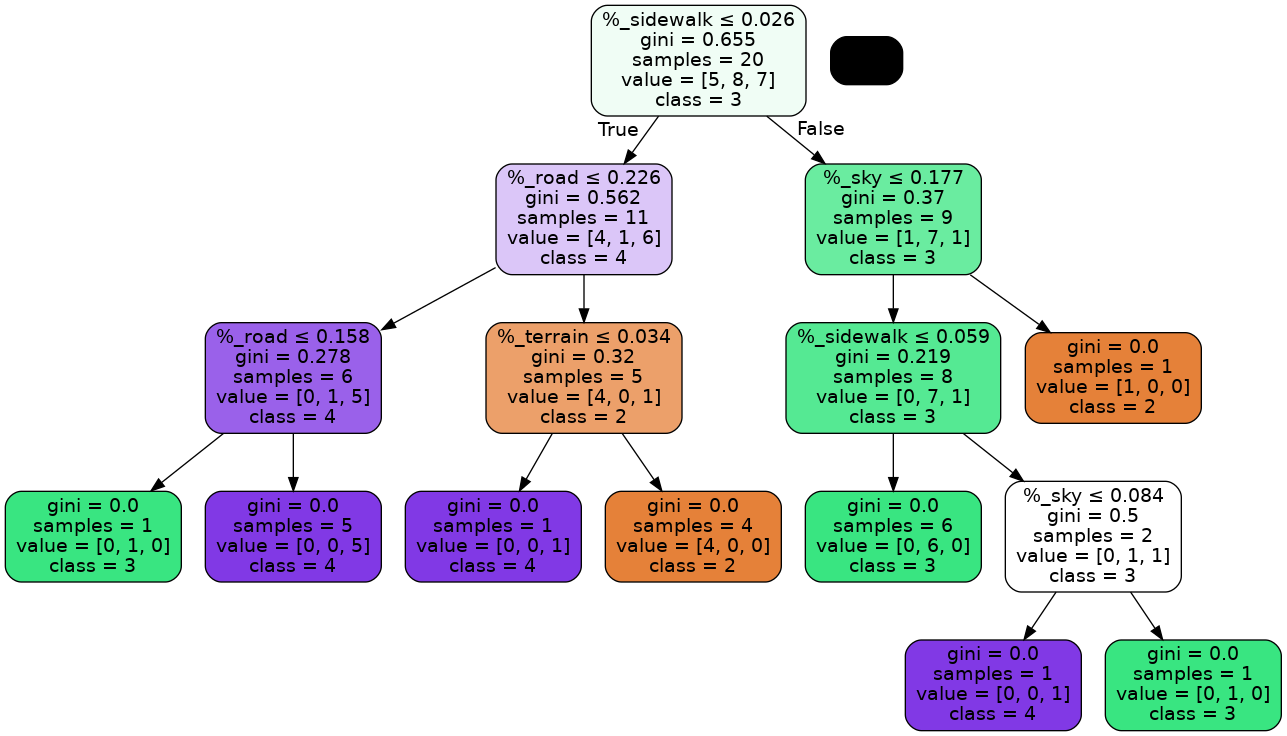

In [208]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['2', '3', '4'])
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Img(graph.create_png())